# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try the TTM-1024-96 or TTM-1536-96 model.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](ibm-granite/granite-timeseries-ttm-r1).

1. TTM-R1 pre-trained models can be found here: [TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
    1. For 512-96 model set `TTM_MODEL_REVISION="main"`
    2. For 1024-96 model set `TTM_MODEL_REVISION="1024_96_v1"`
2. TTM-R2 pre-trained models can be found here: [TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
    1. For 512-96 model set `TTM_MODEL_REVISION="main"`
    2. For 1024-96 model set `TTM_MODEL_REVISION="1024-96-r2"`
    3. For 1536-96 model set `TTM_MODEL_REVISION="1536-96-r2"`

Details about the revisions (R1 and R2) can be found [here](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

## Installation

In [1]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.12"

## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

## Important arguments

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "ettm2"
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

# ----- TTM model path -----
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

# ----- TTM model branch -----
# For R2 models
TTM_MODEL_REVISION = "main"
# TTM_MODEL_REVISION="1024-96-r2"
# TTM_MODEL_REVISION="1536-96-r2"

# For R1 models
# TTM_MODEL_REVISION = "main"
# TTM_MODEL_REVISION="1024_96_v1"

## Data processing pipeline

**Note:** Here we demonstrate how to use the TimeSeriesPreprocessor (TSP) module for data preparation. A step-by-step usage is shown below. For standard datasets, TSP can quickly prepare the dataloaders using YAML files defined [here](https://github.com/ibm-granite/granite-tsfm/tree/main/tsfm_public/resources/data_config). Refer to the [TTM Getting Started](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/ttm_getting_started.ipynb) for example usage. Similar YAML file can be written for any new dataset as well.


In [3]:
# Load the data file and see the columns
df_tmp = pd.read_csv(DATA_ROOT_PATH)
df_tmp

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,42.722000,12.230,54.014000,12.652,-11.525,-1.418,45.986500
69676,2018-06-26 19:00:00,38.868000,10.052,49.859001,10.669,-11.525,-1.418,45.986500
69677,2018-06-26 19:15:00,39.622002,11.057,50.448002,11.795,-10.299,-1.418,45.546501
69678,2018-06-26 19:30:00,40.459999,11.392,51.841999,11.929,-11.536,-1.418,45.546501


<Axes: xlabel='date'>

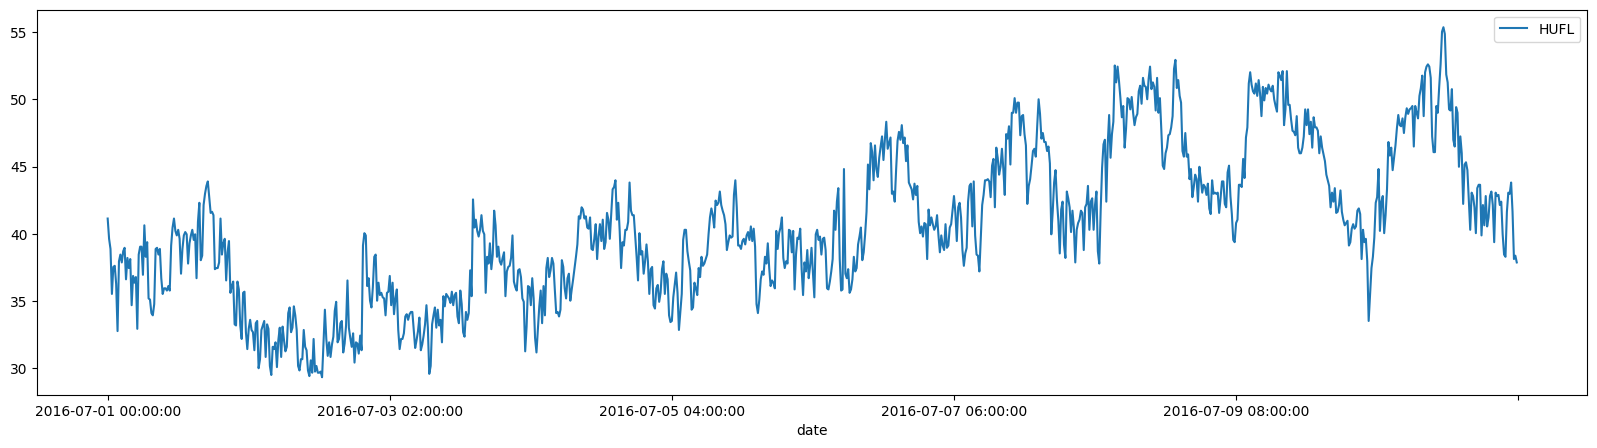

In [4]:
df_tmp.iloc[:1000].plot(x="date", y="HUFL", figsize=(20, 5))

In [5]:
dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 12 * 30 * 24 * 4],
    "valid": [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4],
    "test": [
        12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,
        12 * 30 * 24 * 4 + 8 * 30 * 24 * 4,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 1607, val = 11425, test = 11425


In [6]:
train_dataset[3]

{'past_values': tensor([[-0.5775, -0.6695, -0.8346,  ...,  0.6982,  0.4231,  0.8852],
         [-0.3855, -0.4692, -0.7535,  ...,  0.6982,  0.4231,  0.8852],
         [-0.3775, -0.4329, -0.7964,  ...,  0.5860,  0.4332,  0.8662],
         ...,
         [-0.4895, -0.3419, -0.8187,  ...,  0.3408,  0.2795,  0.4678],
         [-0.4175,  0.2039, -0.6978,  ...,  0.3408,  0.4231,  0.4678],
         [-0.3295,  0.3494, -0.6485,  ...,  0.3408,  0.2795,  0.5058]]),
 'future_values': tensor([[ 0.0146,  0.6224, -0.4735,  0.8561,  0.3408,  0.2795,  0.5058],
         [-0.1215,  0.5314, -0.4974,  0.7497,  0.3408,  0.2795,  0.4868],
         [ 0.0787,  0.7317, -0.3686,  0.9801,  0.3408,  0.2795,  0.4868],
         [ 0.1747,  0.7679, -0.3193,  1.0244,  0.3408,  0.2795,  0.4868],
         [-0.3295,  0.0221, -0.6771, -0.0567,  0.3408,  0.2795,  0.4868],
         [-0.5535, -0.2327, -0.8489, -0.4289,  0.3408,  0.2795,  0.5058],
         [-0.5455, -0.3237, -0.8521, -0.6150,  0.3408,  0.2795,  0.5437],
        

## Zero-shot evaluation method

In [7]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION)
zeroshot_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [8]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
        seed=SEED,
    ),
)

In [9]:
zeroshot_trainer.evaluate(test_dataset)

/Users/wmgifford/miniforge3/envs/granite-tsfm-del/lib/python3.11/site-packages/tsfm_public/models/tinytimemixer/modeling_tinytimemixer.py:1907: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:361.)
  loss_val = loss(y_hat[fut_mask_bool], future_values[fut_mask_bool])


{'eval_loss': 0.17649634182453156,
 'eval_model_preparation_time': 0.001,
 'eval_runtime': 5.8471,
 'eval_samples_per_second': 1953.96,
 'eval_steps_per_second': 30.613}

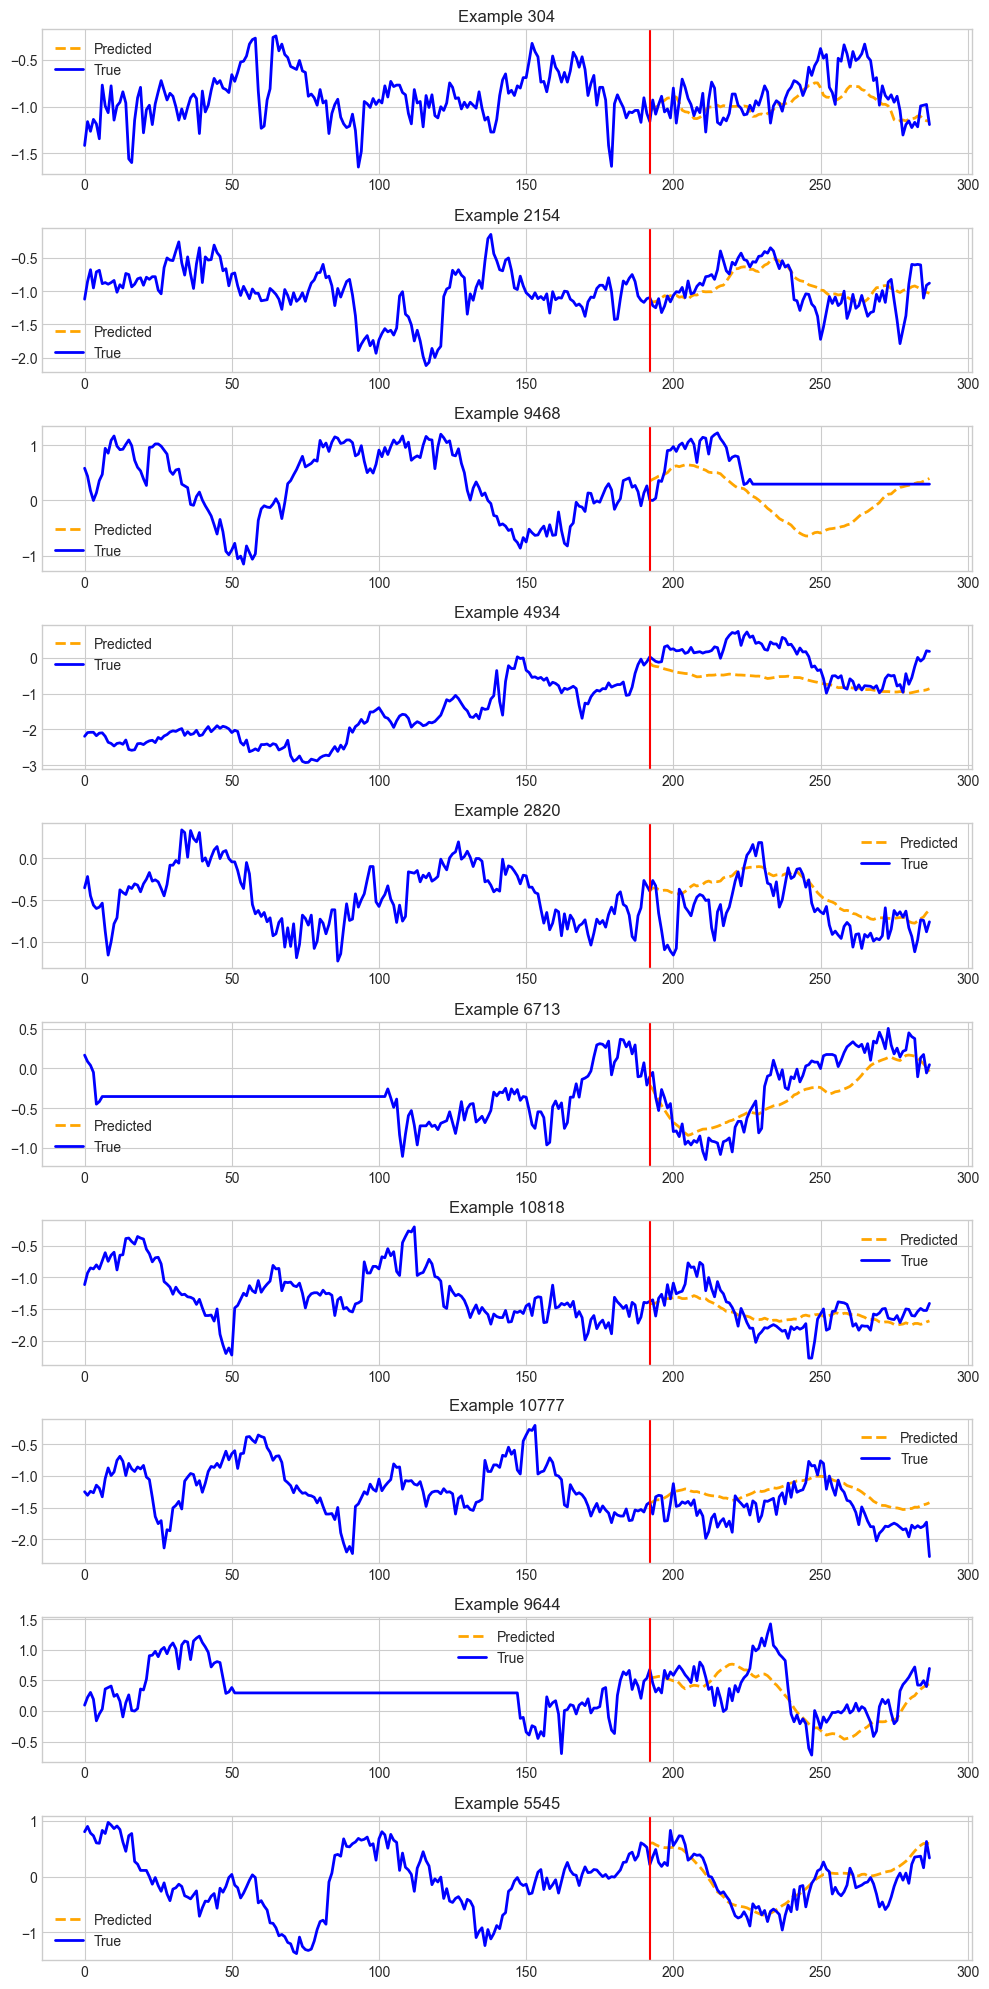

In [10]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "ettm2"),
    plot_prefix="test_zeroshot",
    channel=0,
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [11]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, head_dropout=0.7
)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.4, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.4, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

### Frezze the TTM backbone

In [12]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


### Finetune few-shot 5%

In [13]:
# Important parameters
learning_rate = 0.001
num_epochs = 1  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [14]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    seed=SEED,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.196100,0.138274


[TrackingCallback] Mean Epoch Time = 60.21784973144531 seconds, Total Train Time = 240.08286333084106


TrainOutput(global_step=26, training_loss=0.19609434788043684, metrics={'train_runtime': 240.0827, 'train_samples_per_second': 6.694, 'train_steps_per_second': 0.108, 'total_flos': 27828002979840.0, 'train_loss': 0.19609434788043684, 'epoch': 1.0})

In [15]:
finetune_forecast_trainer.evaluate(test_dataset)

{'eval_loss': 0.18770624697208405,
 'eval_runtime': 62.2802,
 'eval_samples_per_second': 183.445,
 'eval_steps_per_second': 2.874,
 'epoch': 1.0}

## Hands-on Questions

### Q 15.	Zero-shot on etth1. 
In your notebook, modify the zero-shot code to try it on etth1 dataset. Etth1 is available on https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv. 
Use the following train/val/test splits:
```
split_config = {
                "train": [0, 12 * 30 * 24],
                "valid": [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24],
                "test": [
                    12 * 30 * 24 + 4 * 30 * 24,
                    12 * 30 * 24 + 8 * 30 * 24,
                ],
            }
```

### Q 16.	Zero-shot on etth1 by truncating the length
Let’s say your application needs to forecast 24 hours in the future. You can still use the 512-96 TTM model and set `prediction_filter_length=24` argument during model loading. Try it on etth1, and note the evaluation error (on all channels)?

### Q 17.	Few-shot on etth1
Try few-shot 5% forecasting on etth1. Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

### Q 18.	Few-shot on etth1 by changing loss function
Try few-shot 5% forecasting on etth1 by changing the `loss` to `mae` (mean absolute error). Freeze the backbone and fine-tune for only 1 epoch. What is the evaluation error you get?

### Q 19.	Zero-shot on channel 0 and 2 for etth1
In your notebook, add `prediction_channel_indices=[0,2]` during model loading to forecast only 0th and 2nd channels. In this case, execute the following code and note the output shape.
```
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_PATH, revision=TTM_MODEL_REVISION, prediction_channel_indices=[0,2])
output = zeroshot_model.forward(test_dataset[0]['past_values'].unsqueeze(0), return_loss=False)
output.prediction_outputs.shape
```